In [6]:
%matplotlib inline
import matplotlib.pyplot as plt, deal_fig_style as dfs, seaborn as sns
import numpy as np, scipy.special as ss, scipy.optimize as sciop, scipy.stats as stats
import pickle, os, json, h5py, pdf_ccdf as pdf, pandas as pd, gdal
figsize = dfs.set_style(plt.rcParams, plt.gca(), perso_linewidth=0.4)
plt.close()

In [7]:
def rast2arr_elev(raster, lon, lat, calc_flag):
    f_name = '%s_%s_%s_%s_elevation_profile.pkl' % (lon[0], lon[1], lat[0], lat[1])
    if calc_flag == 1:
        ds = gdal.Open(raster)
        nparray = np.flipud(np.array(ds.GetRasterBand(1).ReadAsArray()))
        width = ds.RasterXSize
        height = ds.RasterYSize
        gt = ds.GetGeoTransform()
        minx = gt[0]
        miny = gt[3] + width*gt[4] + height*gt[5]
        maxx = gt[0] + width*gt[1] + height*gt[2]
        maxy = gt[3]
        fullon = [minx, maxx]
        fullat = [miny, maxy]
        leni = np.linspace(lat[0], lat[1], (lat[1] - lat[0])*4+1).shape[0]
        lenj = np.linspace(lon[0], lon[1], (lon[1] - lon[0])*4+1).shape[0]
        max_elev = np.zeros([leni, lenj])
        min_elev = np.zeros([leni, lenj])
        mean_elev = np.zeros([leni, lenj])
        for ii, ilat in enumerate(np.linspace(lat[0], lat[1], (lat[1] - lat[0])*4+1)):
            for jj, jlon in enumerate(np.linspace(lon[0], lon[1], (lon[1] - lon[0])*4+1)):
                lat_min = int((ilat - fullat[0])/gt[1])
                lat_max = int((ilat+0.25 - fullat[0])/gt[1])
                lon_min = int((jlon - fullon[0])/gt[1])
                lon_max = int((jlon+0.25 - fullon[0])/gt[1])
                elev = nparray[lat_min:lat_max, lon_min:lon_max]
                max_elev[ii,jj] = np.max(np.max(elev))
                mean_elev[ii,jj] = np.mean(np.mean(elev))
                min_elev[ii,jj] = np.min(np.min(elev))
        
        elev_data = {'min_elev': min_elev, 'mean_elev': mean_elev, 'max_elev': max_elev}
        pickle.dump(elev_data, open(f_name, 'wb'))

    else:
        elev_data = pickle.load(open(f_name, 'rb'))

    return elev_data['min_elev'], elev_data['mean_elev'], elev_data['max_elev']

In [8]:
names = [
'alpha_hats_WS',
# 'beta_hats_WS',
'mean_hats_WS',
'lambda_hats_WS',
# 'sample_size_WS',
# 'alpha_errors_WS',
# 'beta_errors_WS',
# 'mean_errors_WS',
# 'r2s_WS',
# 'WS_start',
# 'WS_len',
    ]

# load data
lat = [25, 35]
lon = [70, 100]
path_name = '/Users/deale/Dropbox/phd/projects/precipitation_variability/1_data/'

data_in = {}
for dataset in ['TRMM']:

    for name in names:
        print 'Working on %s' % name

        if dataset == 'AFRO':
            # ranges = [0, 1.8, 7]
            # ranges = [0, 20, 11]
            # ranges = [0.6, 1, 9]
            # ranges = [0, 8000, 9]
            with h5py.File(path_name+'APHRODITE.hdf5') as f:

                # # load precip dataset
                data_m = f['Full/'+name][...]
                latitude = f['Full/latitude'][...]
                longitude = f['Full/longitude'][...]

        if dataset == 'TRMM':
            with h5py.File(path_name+'TRMM.hdf5') as f:

                # # load precip dataset
                data_m = f['Full/'+name][...]
                latitude = f['Full/latitude'][...]
                longitude = f['Full/longitude'][...]

        lat_vec = latitude
        lon_vec = longitude
        idy = np.where((lat_vec >= lat[0]) & (lat_vec <= lat[1]))[0]
        idx = np.where((lon_vec >= lon[0]) & (lon_vec <= lon[1]))[0]
        data_in[name] = data_m
        data_in[name] = data_in[name][idy[0]:idy[-1]+1, idx[0]:idx[-1]+1]
        
raster = '/Users/deale/Dropbox/phd/data/DEMs/SRTM_250m/SRTM_NE_250m.tif'
min_elev, mean_elev, max_elev = rast2arr_elev(raster, lon, lat, 1)
print 'Finished!'

data_out = {'Lat': [], 'Lon': [], 'Mean': [], 'Shape': [], 'Freq': [], 'Elev': [],'Relief': []}
for ii, ilat in enumerate(np.linspace(lat[0], lat[1]-0.25, (lat[1] - lat[0])*4)):
    for jj, jlon in enumerate(np.linspace(lon[0], lon[1]-0.25, (lon[1] - lon[0])*4)):
        data_out['Lat'].append(ilat+0.125) 
        data_out['Lon'].append(jlon+0.125) 
        data_out['Mean'].append(data_in['mean_hats_WS'][ii,jj]) 
        data_out['Shape'].append(data_in['alpha_hats_WS'][ii,jj]) 
        data_out['Freq'].append(data_in['lambda_hats_WS'][ii,jj] ) 
        data_out['Elev'].append(mean_elev[ii,jj])
        data_out['Relief'].append(max_elev[ii,jj] - min_elev[ii,jj]) 

DF = pd.DataFrame(data_out)

Working on alpha_hats_WS
Working on mean_hats_WS
Working on lambda_hats_WS
Finished!


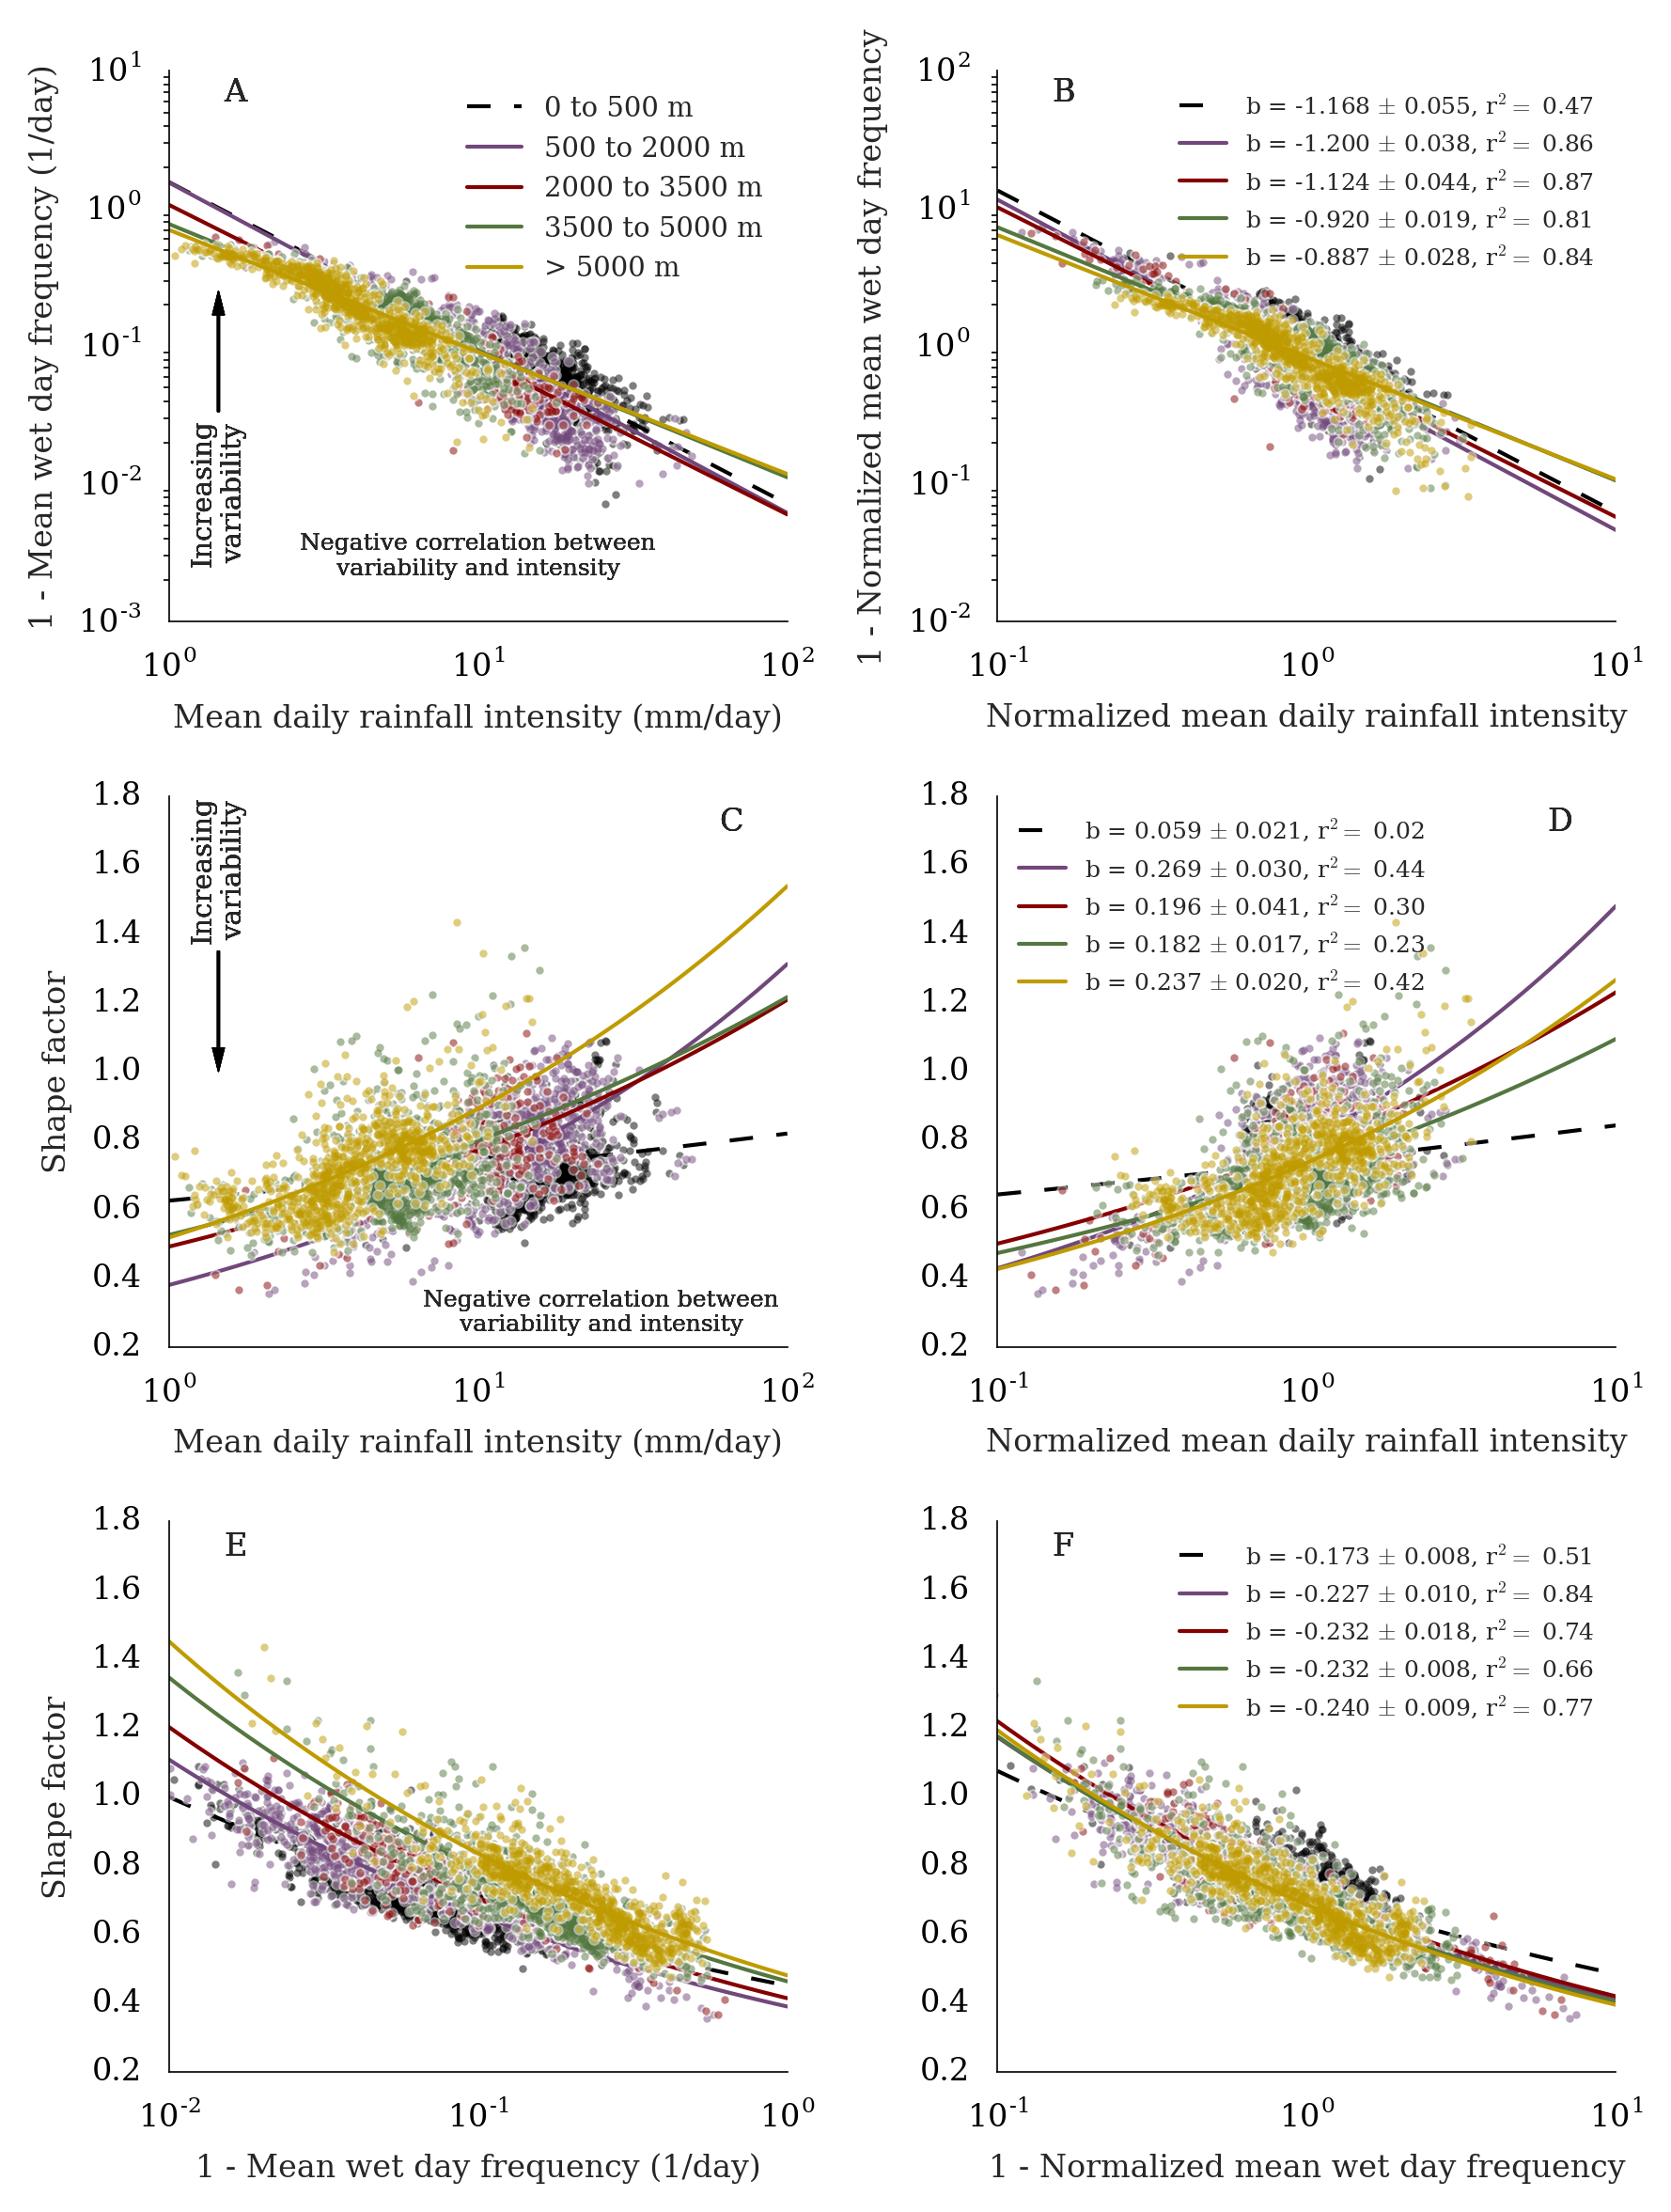

In [9]:
color = ['k', '#71487B', sns.xkcd_rgb['dark red'], '#547740', '#BF9B00']
ls = ['--', '-', '-', '-', '-']
elev_ranges = np.asarray([0, 500, 2000, 3500, 5000, 10000])
label = ['0 to 500 m', '500 to 2000 m', '2000 to 3500 m', '3500 to 5000 m', '> 5000 m']
ms = 4
alpha = 0.5
def f1(x, b, m):
    return b*x**m

fig1 = plt.figure(figsize=(1*figsize[0], 2*figsize[1]))
ax1 = plt.subplot(3,2,3)
for ii in [0, 1, 2, 3, 4]:
    mean_region = np.mean(np.asarray(DF['Mean'][((DF['Elev'] < (elev_ranges[ii+1])) & (DF['Elev'] > elev_ranges[ii]))]))
    shape = np.asarray(DF['Shape'][((DF['Elev'] < (elev_ranges[ii+1])) & (DF['Elev'] > elev_ranges[ii]))])
    mean = np.asarray(DF['Mean'][((DF['Elev'] < (elev_ranges[ii+1])) & (DF['Elev'] > elev_ranges[ii]))])
    ax1.semilogx(mean, shape, '.', color='w', alpha=alpha, ms=ms+2)
    ax1.semilogx(mean, shape, '.', color=color[ii], alpha=alpha, ms=ms)
    
    (b, m), popc = sciop.curve_fit(f1, mean, shape)
    perr = np.sqrt(np.diag(popc))
    residuals = shape - f1(mean, b, m)
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((shape-np.mean(shape))**2)
    r_squared = 1. - (ss_res / ss_tot)
    x = np.logspace(0,2,100)
    ax1.semilogx(x, f1(x, b, m), color=color[ii], lw=1, ls=ls[ii])
    
    ax1.set_ylim([0.2, 1.8])
    ax1.set_xlim([1,100])
    ax1.text(60, 1.7, 'C')
    ax1.set_xlabel('Mean daily rainfall intensity (mm/day)')
    ax1.set_ylabel('Shape factor')
    ax1.text(25, .3, 'Negative correlation between\nvariability and intensity', ha='center', va='center', fontsize=6)
    ax1.annotate('Increasing\nvariability',
             xy=(0.08, 0.5), 
             xytext=(0.08,1), 
             fontsize=7,
             ha='center',
             va='top',
             rotation='vertical',
             xycoords='axes fraction', 
             textcoords='axes fraction',
             arrowprops={'width':0.5, 'headlength':6, 'headwidth':3, 'color':'k'})
    sns.despine()
    
ax2 = plt.subplot(3,2,4)
for ii in [0, 1, 2, 3, 4]:
    mean_region = np.mean(np.asarray(DF['Mean'][((DF['Elev'] < (elev_ranges[ii+1])) & (DF['Elev'] > elev_ranges[ii]))]))
    shape = np.asarray(DF['Shape'][((DF['Elev'] < (elev_ranges[ii+1])) & (DF['Elev'] > elev_ranges[ii]))])
    mean = np.asarray(DF['Mean'][((DF['Elev'] < (elev_ranges[ii+1])) & (DF['Elev'] > elev_ranges[ii]))])
    ax2.semilogx(mean/mean_region, shape, '.', color='w', alpha=alpha, ms=ms+2)
    ax2.semilogx(mean/mean_region, shape, '.', color=color[ii], alpha=alpha, ms=ms)
    
    (b, m), popc = sciop.curve_fit(f1, mean/mean_region, shape)
    perr = np.sqrt(np.diag(popc))
    residuals = shape - f1(mean/mean_region, b, m)
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((shape-np.mean(shape))**2)
    r_squared = 1. - (ss_res / ss_tot)
    x = np.logspace(-1,1,100)
    ax2.semilogx(x, f1(x, b, m), color=color[ii], lw=1, ls=ls[ii],
               label='b = %0.3f $\pm$ %0.3f, r$^2=$ %0.2f' % (m, 2*perr[1], r_squared))
    ax2.legend(loc=0, fontsize=6)
    
    ax2.set_ylim([0.2, 1.8])
    ax2.set_xlim([0.1,10])
    ax2.text(6, 1.7, 'D')
    ax2.set_xlabel('Normalized mean daily rainfall intensity')
#     ax2.set_ylabel('1/(Shape factor)')
    sns.despine()

ax3 = plt.subplot(3,2,5)
for ii in [0, 1, 2, 3, 4]:
    shape = np.asarray(DF['Shape'][((DF['Elev'] < (elev_ranges[ii+1])) & (DF['Elev'] > elev_ranges[ii]))])
    mean = np.asarray(DF['Freq'][((DF['Elev'] < (elev_ranges[ii+1])) & (DF['Elev'] > elev_ranges[ii]))])
    ax3.semilogx((1.-mean), shape, '.', color='w', alpha=alpha, ms=ms+2)
    ax3.semilogx((1.-mean), shape, '.', color=color[ii], alpha=alpha, ms=ms)
    
    (b, m), popc = sciop.curve_fit(f1, (1.-mean), shape)
    perr = np.sqrt(np.diag(popc))
    residuals = shape - f1((1.-mean), b, m)
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((shape-np.mean(shape))**2)
    r_squared = 1. - (ss_res / ss_tot)
    x = np.logspace(-2,0,100)
    ax3.semilogx(x, f1(x, b, m), color=color[ii], lw=1, ls=ls[ii])    
    
    ax3.set_ylim([0.2, 1.8])
    ax3.set_xlim([1e-2, 1])
    ax3.text(0.015, 1.7, 'E')
    ax3.set_xlabel('1 - Mean wet day frequency (1/day)')
    ax3.set_ylabel('Shape factor')
    sns.despine()
    
ax4 = plt.subplot(3,2,6)
for ii in [0, 1, 2, 3, 4]:
    mean_region = np.mean(np.asarray(DF['Freq'][((DF['Elev'] < (elev_ranges[ii+1])) & (DF['Elev'] > elev_ranges[ii]))]))
    shape = np.asarray(DF['Shape'][((DF['Elev'] < (elev_ranges[ii+1])) & (DF['Elev'] > elev_ranges[ii]))])
    mean = np.asarray(DF['Freq'][((DF['Elev'] < (elev_ranges[ii+1])) & (DF['Elev'] > elev_ranges[ii]))])
    ax4.semilogx((1.-mean)/(1.- mean_region), shape, '.', color='w', alpha=alpha, ms=ms+2)
    ax4.semilogx((1.-mean)/(1.- mean_region), shape, '.', color=color[ii], alpha=alpha, ms=ms)
    
    (b, m), popc = sciop.curve_fit(f1,(1.-mean)/(1.- mean_region), shape)
    perr = np.sqrt(np.diag(popc))
    residuals = shape - f1((1.-mean)/(1.- mean_region), b, m)
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((shape-np.mean(shape))**2)
    r_squared = 1. - (ss_res / ss_tot)
    x = np.logspace(-1,1,100)
    ax4.semilogx(x, f1(x, b, m), color=color[ii], lw=1, ls=ls[ii],
               label='b = %0.3f $\pm$ %0.3f, r$^2=$ %0.2f' % (m, 2*perr[1], r_squared))
    ax4.legend(loc=0, fontsize=6)
    
    ax4.set_ylim([0.2, 1.8])
    ax4.set_xlim([0.1,10])
    ax4.set_xlabel('1 - Normalized mean wet day frequency')
    ax4.text(.15, 1.7, 'F')
#     ax4.set_ylabel('Shape factor')
    sns.despine()
    
ax5 = plt.subplot(3,2,1)
for ii in [0, 1, 2, 3, 4]:
    freq = np.asarray(DF['Freq'][((DF['Elev'] < (elev_ranges[ii+1])) & (DF['Elev'] > elev_ranges[ii]))])
    mean = np.asarray(DF['Mean'][((DF['Elev'] < (elev_ranges[ii+1])) & (DF['Elev'] > elev_ranges[ii]))])
    ax5.loglog(mean, (1.-freq), '.', color='w', alpha=alpha, ms=ms+2)
    ax5.loglog(mean, (1.-freq), '.', color=color[ii], alpha=alpha, ms=ms)
    (b, m), popc = sciop.curve_fit(f1, mean, (1.-freq))
    perr = np.sqrt(np.diag(popc))
    x = np.logspace(0,2,100)
    ax5.loglog(x, f1(x, b, m), color=color[ii], lw=1, label=label[ii], ls=ls[ii])
    ax5.set_xlabel('Mean daily rainfall intensity (mm/day)')
    ax5.set_ylabel('1 - Mean wet day frequency (1/day)')
    ax5.set_xlim([1,100])
    ax5.text(1.5, 6, 'A')
    ax5.text(10, .003, 'Negative correlation between\nvariability and intensity', ha='center', va='center', fontsize=6)
    ax5.legend(loc=0, fontsize=7)
    ax5.annotate('Increasing\nvariability',
                 xy=(0.08, 0.6), 
                 xytext=(0.08,0.1), 
                 fontsize=7,
                 ha='center',
                 va='bottom',
                 rotation='vertical',
                 xycoords='axes fraction', 
                 textcoords='axes fraction',
                 arrowprops={'width':0.5, 'headlength':6, 'headwidth':3, 'color':'k'})
    sns.despine()
    
ax6 = plt.subplot(3,2,2)
for ii in [0, 1, 2, 3, 4]:
    mean_region = np.mean(np.asarray(DF['Mean'][((DF['Elev'] < (elev_ranges[ii+1])) & (DF['Elev'] > elev_ranges[ii]))]))
    mean_freq = np.mean(np.asarray(DF['Freq'][((DF['Elev'] < (elev_ranges[ii+1])) & (DF['Elev'] > elev_ranges[ii]))]))
    freq = np.asarray(DF['Freq'][((DF['Elev'] < (elev_ranges[ii+1])) & (DF['Elev'] > elev_ranges[ii]))])
    mean = np.asarray(DF['Mean'][((DF['Elev'] < (elev_ranges[ii+1])) & (DF['Elev'] > elev_ranges[ii]))])
    ax6.loglog(mean/mean_region, (1.-freq)/(1.-mean_freq), '.', color='w', alpha=alpha, ms=ms+2)
    ax6.loglog(mean/mean_region, (1.-freq)/(1.-mean_freq), '.', color=color[ii], alpha=alpha, ms=ms)
    
    (b, m), popc = sciop.curve_fit(f1, mean/mean_region, (1.-freq)/(1.-mean_freq))
    perr = np.sqrt(np.diag(popc))
    residuals = (1.-freq)/(1.-mean_freq) - f1(mean/mean_region, b, m)
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum(((1.-freq)/(1.-mean_freq)-np.mean((1.-freq)/(1.-mean_freq)))**2)
    r_squared = 1. - (ss_res / ss_tot)
    x = np.logspace(-1,1,100)
    ax6.loglog(x, f1(x, b, m), color=color[ii], lw=1,  ls=ls[ii],
               label='b = %0.3f $\pm$ %0.3f, r$^2=$ %0.2f' % (m, 2*perr[1], r_squared))
    ax6.legend(loc=0, fontsize=6)
    
    ax6.set_xlabel('Normalized mean daily rainfall intensity')
    ax6.set_ylabel('1 - Normalized mean wet day frequency')
    ax6.set_xlim([0.1,10])
    ax6.text(0.15, 60, 'B')
    sns.despine()
    
plt.tight_layout()
plt.savefig('big_cor_TRMM.pdf', dpi=600, format='pdf')

//anaconda/lib/python2.7/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


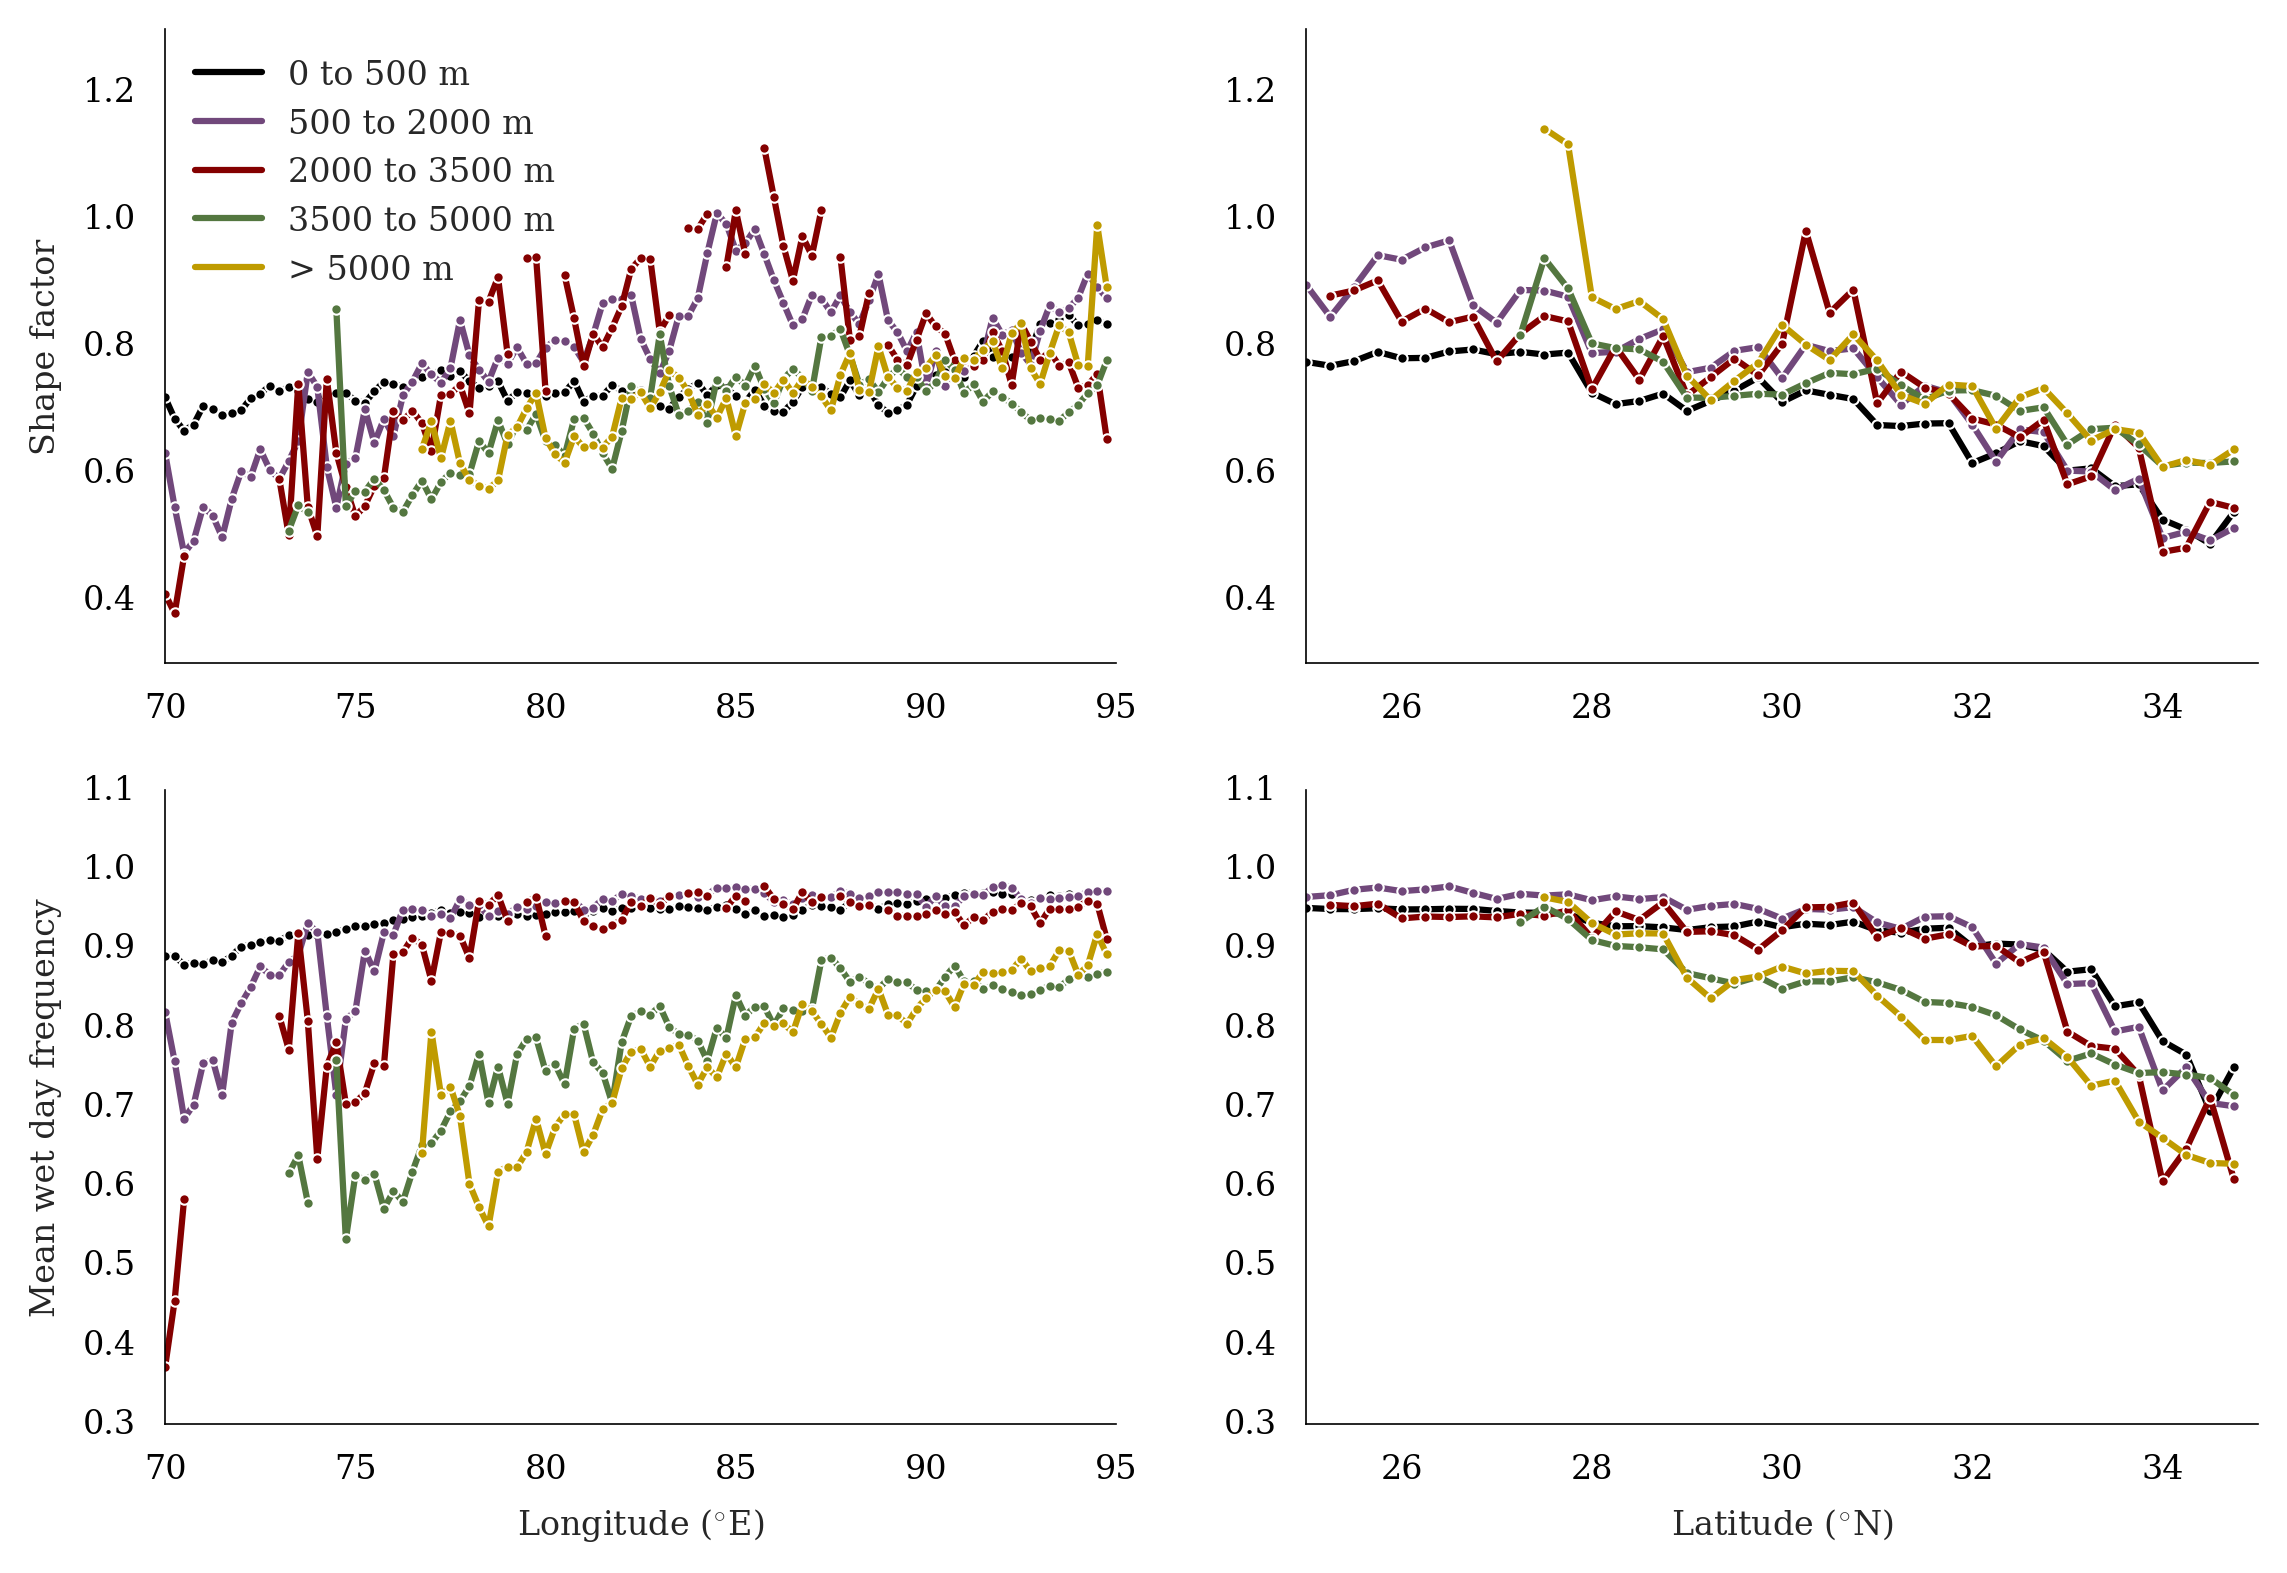

In [10]:
# color = ['k', 'b', 'y', 'm', 'g']
color = ['k', '#71487B', sns.xkcd_rgb['dark red'], '#547740', '#BF9B00']
elev_ranges = np.asarray([0, 500, 2000, 3500, 5000, 10000])
label = ['0 to 500 m', '500 to 2000 m', '2000 to 3500 m', '3500 to 5000 m', '> 5000 m']

def run_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N

fig1 = plt.figure(figsize=(1.5*figsize[0], 1.5*figsize[1]))
ax1 = plt.subplot(2,2,1)
lon_vec = np.linspace(70, 94.75, 100)
for ii in [0, 1, 2, 3, 4]:
#     mean_region = np.mean(np.asarray(DF['Mean'][((DF['Elev'] < (elev_ranges[ii]+1000.)) & (DF['Elev'] > elev_ranges[ii]))]))
    DF_shape = DF[((DF['Elev'] < (elev_ranges[ii+1])) & (DF['Elev'] > elev_ranges[ii]))]
    shape_lat = np.zeros(100)
    for jj, ilon in enumerate(lon_vec):
        shape_lat[jj] = np.mean(np.asarray(DF_shape['Shape'][DF_shape['Lon'] == ilon+0.125]))
    
#     print shape_lat.size
#     shape_lat[2:] = run_mean(shape_lat, 3)
#     print shape_lat.size
#     print shape_lat

    ax1.plot(lon_vec, shape_lat, color=color[ii], lw=1.5, label=label[ii])
    ax1.plot(lon_vec, shape_lat, '.', color='w', ms = 6)
    ax1.plot(lon_vec, shape_lat, '.', color=color[ii], ms = 4)
    ax1.legend(loc=0, fontsize=8)
    ax1.set_ylim([0.3, 1.3])
#     ax1.set_xlabel('Longitude ($^{\circ}$E)')
    ax1.set_ylabel('Shape factor')
    sns.despine()
    
ax2 = plt.subplot(2,2,3)
for ii in [0, 1, 2, 3, 4]:
    DF_shape = DF[((DF['Elev'] < (elev_ranges[ii]+1500.)) & (DF['Elev'] > elev_ranges[ii]))]
    shape_lat = np.zeros(100)
    for jj, ilon in enumerate(lon_vec):
        shape_lat[jj] = np.mean(np.asarray(DF_shape['Freq'][DF_shape['Lon'] == ilon+0.125]))
        
    ax2.plot(lon_vec, shape_lat, color=color[ii], lw=1.5)
    ax2.plot(lon_vec, shape_lat, '.', color='w', ms = 6)
    ax2.plot(lon_vec, shape_lat, '.', color=color[ii], ms = 4, label=label[ii])
#     ax2.legend(loc=4, fontsize=6)
    ax2.set_ylim([.3, 1.1])
    ax2.set_xlabel('Longitude ($^{\circ}$E)')
    ax2.set_ylabel('Mean wet day frequency')
    sns.despine()
    
ax3 = plt.subplot(2,2,2)
lon_vec = np.linspace(25, 34.75, 40)
for ii in [0, 1, 2, 3, 4]:
    DF_shape = DF[((DF['Elev'] < (elev_ranges[ii]+1500.)) & (DF['Elev'] > elev_ranges[ii]))]
    shape_lat = np.zeros(40)
    for jj, ilon in enumerate(lon_vec):
        shape_lat[jj] = np.mean(np.asarray(DF_shape['Shape'][DF_shape['Lat'] == ilon+0.125]))
        
    ax3.plot(lon_vec, shape_lat, color=color[ii], lw=1.5)
    ax3.plot(lon_vec, shape_lat, '.', color='w', ms = 6)
    ax3.plot(lon_vec, shape_lat, '.', color=color[ii], ms = 4, label=label[ii])
#     ax3.legend(loc=0, fontsize=8)
    ax3.set_ylim([0.3, 1.3])
    ax3.set_xlim([25, 35])
#     ax3.set_xlabel('Latitude ($^{\circ}$N)')
#     ax3.set_ylabel('Shape factor')
    sns.despine()
    
ax4 = plt.subplot(2,2,4)
for ii in [0, 1, 2, 3, 4]:
    DF_shape = DF[((DF['Elev'] < (elev_ranges[ii]+1500.)) & (DF['Elev'] > elev_ranges[ii]))]
    shape_lat = np.zeros(40)
    for jj, ilon in enumerate(lon_vec):
        shape_lat[jj] = np.mean(np.asarray(DF_shape['Freq'][DF_shape['Lat'] == ilon+0.125]))
        
    ax4.plot(lon_vec, shape_lat, color=color[ii], lw=1.5)
    ax4.plot(lon_vec, shape_lat, '.', color='w', ms = 6)
    ax4.plot(lon_vec, shape_lat, '.', color=color[ii], ms = 4, label=label[ii])
#     ax2.legend(loc=2, fontsize=6)
    ax4.set_ylim([0.3, 1.1])
    ax4.set_xlim([25, 35])
    ax4.set_xlabel('Latitude ($^{\circ}$N)')
#     ax4.set_ylabel('Mean wet day frequency')
    sns.despine()

plt.savefig('lat_lon_variations_AFRO.pdf', dpi=600, format='pdf')